# Explore Surface Change

![UKy's central campus in lidar point cloud](https://nyc3.digitaloceanspaces.com/astoria/geo409/images/lidar-banner.jpg)     
*UKy's central campus in lidar point cloud*


This notebook uses raster derivatives from Phase 1 and Phase 2 lidar point clouds. It will show increase and decrease in surface height between phases and suggest a way to visualize them as raster overlays and colorized point clouds.

In [72]:
############### Modules and Functions :: DO NOT EDIT ###############

# Import ArcGIS package
import arcpy
# Subprocess allows us to issue commands on the command line
import subprocess
# Get current local time
from datetime import datetime

# Allow overwriting of existing data
arcpy.env.overwriteOutput = True

# Set coordinate system to Kentucky
ky = arcpy.SpatialReference(3089)
arcpy.env.outputCoordinateSystem = ky

# Do not add newly created layers to map
arcpy.env.addOutputsToMap = False

############### Utility functions ###############

def setWork():
    """Create dictionary of path names from global variables 
    and return dot.notation access to dictionary attributes.
    Used internally for shorthand access to path names."""
    class dotdict(dict):
        """dot.notation"""
        __getattr__ = dict.get
        __setattr__ = dict.__setitem__
        __delattr__ = dict.__delitem__
    p = {
        "project": f'{root}\\{folder}',
        "db": f'{root}\\{folder}\\{folder}.gdb',
        "lidar": f'{root}\\{folder}\\las',
        "download": f'{root}\\{folder}\\laz',
        "laz": f"{root}\\tools\\LAStools\\bin\\laszip64.exe",
        "lasmerge": f"{root}\\tools\\LAStools\\bin\\lasmerge64.exe",
        "grid":  f"{root}\\tools\\grids\\tile-grids.gdb\\KY_5k_LAZ",
        "lasd": f'{root}\\{folder}\\download\\combined.lasd',
        "lasdaoi": f'{root}\\{folder}\\download\\aoi_extract.lasd',
        "lasdaoim": f'{root}\\{folder}\\download\\aoi_merged.lasd',
        "merge": f'{root}\\{folder}\\download\\merged.las',
        "aoi": f'{root}\\{folder}\\download\\aoi.lasd',
        "bands": 'RED Band_1; GREEN Band_2; BLUE Band_3',
        "img": "ImageServices\\Ky_NAIP_2020_2ft",
        "dsm": f'{root}\\{folder}\\lidar\\dsm.lasd',
        "output": 'aoi',
        "name": folder,
        "potree": f"{root}\\tools\\potree\\PotreeConverter.exe",
        "potree2": f"{root}\\tools\\potree2\\PotreeConverter.exe"
        
    }
    return dotdict(p)

def listContents(root, folder):
    """Function to print contents of a directory and report time when the cell finished processing.
    listContents(root, folder)
    Two arguments:
        root = drive letter and folder for your root GIS space (string)
        folder = path to folder in root (string)
    """
    downloads = f'{root}\\{folder}'
    completed = subprocess.run(f'dir {downloads}', shell=True, stdout=subprocess.PIPE)
    print(completed.stdout.decode('UTF-8'))
    print("Finished processing", datetime.now())

def checkFolder(name):
    """Function to check folder name against special characters for creating project space.
    checkFolder(name)
    One argument:
        name = name of project folder for this application (string)
    """
    special = "\"\' :;\\.!@#$%^&*()-+?=,<>/"
    if any(letter in special for letter in name):
        print("Whoops! You have a special character in your project's name. \nPlease change project name.")
        return False
    else:
        print(f'Checking project folder...')
        return True
    
############### Project Functions :: DO NOT EDIT ###############

def setUpProject():
    """Function to create project folder and database in root GIS.
    setUpProject()
    No arguments
    """
    p = setWork()
    if checkFolder(folder):
        subprocess.run(f'mkdir {p.project}', shell=True)
        print(f'Your project is in the {p.project} folder')
    # Create project geodatabase
    try:
        test_workspace = arcpy.Describe(p.db)
        if test_workspace.dataType == 'Workspace':
            print(f"Output database already exists: {p.db}")
    except:
        arcpy.management.CreateFileGDB(p.project, folder)
        print(f"Created output database: {p.db}")   
    arcpy.env.workspace = p.db
    print(f"Using {arcpy.env.workspace} for output")
            

# function to estimate time remaining
def time_difference(start, n):
    # get datetime.now() and use as start argument
    # n is number of expected steps until loop is completed
    current_datetime = datetime.now()
    seconds = round((current_datetime - start).total_seconds(), 1)
    minutes = round((n * seconds) / 60, 1)
    if n > 1:
        s = f' With {n} steps remaining: {minutes}m.'
    else:
        s = ''
    print (f"Process took {minutes}m ({seconds}s) to complete.{s}")
    return seconds

## Before you start
* Create DSMs from two KyFromAbove phases.
* Create a new Local Scene Project in your root GIS folder.

In [80]:
############### Global variables :: EDIT for your AOI ###############

# Directory path to your root GIS folder. 
root = "u:\\BoydsGIS"

# Project name - creates a folder in your root GIS directory.
# Use only letters and underscores, no numbers, spaces, etc.
# can be an existing project. It will not overwrite it.
folder = "LexChange"

# Set years for comparison
t1 = 2010
t2 = 2019

# Paths to DSMs
pathT1 = r'U:\BoydsGIS\NewCircle_Phase1\NewCircle_Phase1.gdb\dsm'
pathT2 = r'U:\BoydsGIS\NewCircle_Phase2\NewCircle_Phase2.gdb\dsm'

In [81]:
# Setup project space
setUpProject()

Checking project folder...
Your project is in the u:\BoydsGIS\LexChange folder
Output database already exists: u:\BoydsGIS\LexChange\LexChange.gdb
Using u:\BoydsGIS\LexChange\LexChange.gdb for output


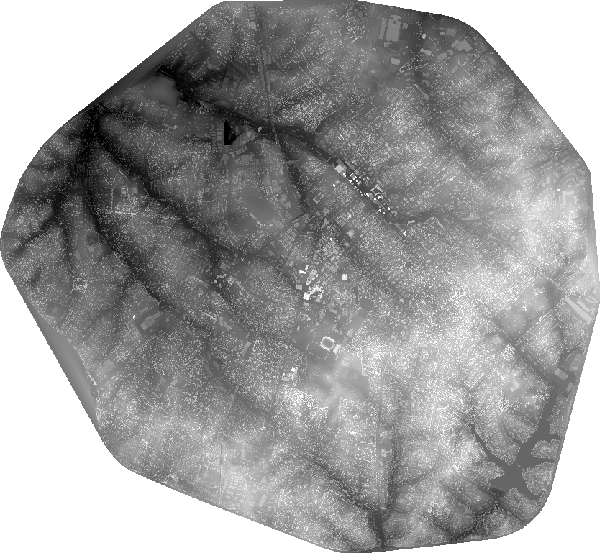

In [82]:
# Load and verify DSMs
dsmT1 = arcpy.sa.Raster(pathT1)
dsmT1

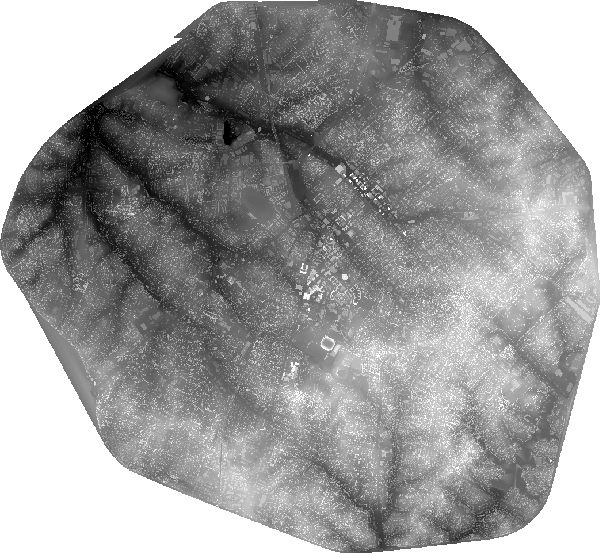

In [78]:
# Load and verify DSMs
dsmT2 = arcpy.sa.Raster(pathT2)
dsmT2

## Comparing DSM change 
After two DSM from different years are loaded, compare change by subtracting the older DSM from the recent DSM.

In [84]:
# Do not add newly created layers to map
arcpy.env.addOutputsToMap = True
change_uncleaned = (dsmT2 - dsmT1)

In [85]:
# Smooth surface to remove artifacts along the edges of tall structures
neighborhood = arcpy.sa.NbrRectangle(3, 3, 'CELL')
change = arcpy.sa.FocalStatistics(change_uncleaned, neighborhood , 'MEDIAN')

In [86]:
# Where has there been increase and decrease in height
filled = arcpy.sa.Con((change > 2), change, 0)
removed = arcpy.sa.Con((change < -2), change, 0)

In [87]:
filled.save(f'filled_{t2}')
removed.save(f'removed_{t1}')

In [94]:
removed = arcpy.sa.Raster('removed_2010')
ndvi = arcpy.sa.Raster(r'U:\BoydsGIS\NewCircle_Phase1\NewCircle_Phase1.gdb\ndvi_2010')

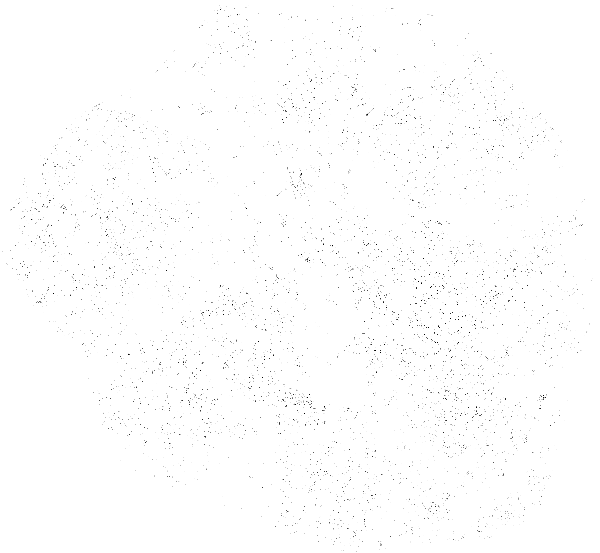

In [96]:
trees_removed = arcpy.sa.Con((ndvi > 0.1) & (removed < -10), removed)
trees_removed.save('trees_removed_over_10ft')
trees_removed

In [97]:
filled = arcpy.sa.Raster('filled_2019')
ndvi = arcpy.sa.Raster(r'U:\BoydsGIS\NewCircle_Phase2\NewCircle_Phase2.gdb\ndvi_2018')

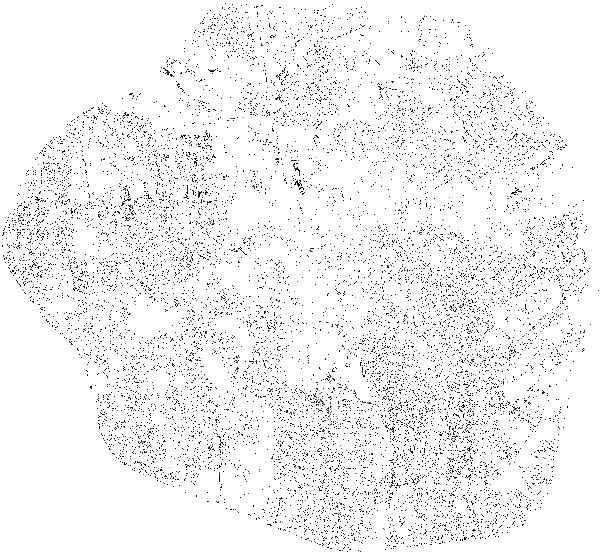

In [98]:
trees_filled = arcpy.sa.Con((ndvi > 0.1) & (filled > 8), filled)
trees_filled.save('trees_filled_over_8ft')
trees_filled

In [100]:
# Reclassify old values to new range
# format [old_lo, old_high, new_value], next new class, etc. 
reramp = arcpy.sa.RemapRange([[-2000,-80,1],[-80,-60,2],[-60,-40,3],[-40,-20,4],[-20,-10,5]])
trees_removed_classed = arcpy.sa.Reclassify(trees_removed, "Value", reramp, "NODATA")
trees_removed_classed.save('trees_removed_classed')

In [107]:
# Get stats for each new class
resolution = 5
sumCover = 0
with arcpy.da.SearchCursor('trees_removed_classed' , ['Count']) as cursor:
    for row in cursor:
        sumCover += row[0]
with arcpy.da.SearchCursor('trees_removed_classed', ['Count', 'Value']) as cursor:
    for row in cursor:
        a = (row[0]/sumCover) * 100
        b = (row[0] * resolution**2) / 43560
        a = round(a, 2)
        b = round(b, 1)
        c = f'{a}%, {b} acres of {row[1]}'
        print(c)

0.14%, 1.0 acres of 1
3.09%, 21.9 acres of 2
16.69%, 117.9 acres of 3
40.19%, 283.9 acres of 4
39.89%, 281.8 acres of 5


In [108]:
print((sumCover*resolution**2)/773529557.080543)

0.039780412678911976


In [104]:
# Reclassify old values to new range
# format [old_lo, old_high, new_value], next new class, etc. 
reramp = arcpy.sa.RemapRange([[8,10,1],[10,20,2],[20,30,3],[30,40,4],[40,170,5]])
trees_filled_classed = arcpy.sa.Reclassify(trees_filled, "Value", reramp, "NODATA")
trees_filled_classed.save('trees_filled_classed')

In [105]:
# Get stats for each new class
resolution = 5
sumCover = 0
with arcpy.da.SearchCursor('trees_filled_classed' , ['Count']) as cursor:
    for row in cursor:
        sumCover += row[0]
with arcpy.da.SearchCursor('trees_filled_classed', ['Count', 'Value']) as cursor:
    for row in cursor:
        a = (row[0]/sumCover) * 100
        b = (row[0] * resolution**2) / 43560
        a = round(a, 2)
        b = round(b, 1)
        c = f'{a}%, {b} acres of {row[1]}'
        print(c)

21.98%, 267.2 acres of 1
58.37%, 709.6 acres of 2
15.46%, 187.9 acres of 3
3.28%, 39.8 acres of 4
0.92%, 11.1 acres of 5


In [106]:
print((sumCover*resolution**2)/773529557.080543)

0.06845895481985585


## Symbolize and export change raster
Symbolize each raster and then export as RBG raster by right-clicking the raster layer in the **Contents Pane > Data > Export Raster** and enable **RGB** out and **Force RGB**. This layer can then been used coloring the shaded relief basemap in a Layout or other graphic applications.

![Export Raster](https://nyc3.digitaloceanspaces.com/astoria/geo409/images/export_raster.jpg)

## Colorize point cloud
You'll need the original LASD for colorizing.

In [ ]:
# Edit workspace properties for custom colorized las files

# Set root GIS folder
rootGIS = 'u:\\BoydsGIS'

# Set project name (should be folder name and the name of the lAS dataset)
projectName = 'NewCircle_Phase2'

# Analysis name (will create a folder to store output colorized lass files)
analysisName = 'filled'

# Image to use to colorize las file
inImage = f'u:\\BoydsGIS\\LexChange\\LexChange.gdb\\filled_{t2}_rgb'

# Bands in this image
bands = 'RED Band_1; GREEN Band_2; BLUE Band_3'

In [ ]:
# Set paths for function. Likely will not have to edit.
inCloud = f'{rootGIS}\\{projectName}\\lidar\\{projectName}.lasd'
lidarFolder = f'{rootGIS}\\{projectName}\\lidar\\{analysisName}'
lasSuffix = f'_{analysisName}'
outCloud =  f'{rootGIS}\\{projectName}\\lidar\\{projectName}_{analysisName}.lasd'

In [ ]:
# Check if files exist...
listContents(rootGIS, f'{projectName}\\lidar\\')
print(f'Do you see {rootGIS}\\{projectName}\\lidar\\{projectName}.lasd ?')

In [ ]:
# Make folder for colorized las files
subprocess.run(f'mkdir {lidarFolder}', shell=True, stdout=subprocess.PIPE)

In [ ]:
# Colorize point cloud
arcpy.ddd.ColorizeLas(inCloud, inImage, bands, lidarFolder, lasSuffix,"#", "#", "#", "#", "#", outCloud)

### Repeat  for both phases

Add both colorized point clouds to a scene.

![Colorize point cloud](https://nyc3.digitaloceanspaces.com/astoria/geo409/images/colorized_point_cloud.jpg)